# Convolutional Neural Networks

## Setup
1. Öffne das Notebook in **Google Colab**! Google Colab bietet eine Option für kostenlose GPU- und TPU-runtime. Dies wird die Trainingszeiten Ihres Modells erheblich reduzieren.
   1. Gehe auf https://colab.google/ und clicke auf "Open Colab" (oder "Sign Up" falls noch kein Account existiert)
   2. Clicke auf "File", dann "Upload Notebook" und selektiere dieses Notebook
   3. Click auf "Runtime", dann "Change runtime type" und selektiere "T4 GPU"
4. Führe alle Imports in durch und installiere ggf. fehlende Pakete
5. Führe den zweiten Setup Abschnitt aus, sodass alle nötigen Funktionen erstellt werden
6. Führe den dritten Setup Abschnitt aus, sodass alle Daten geladen und bearbeitet werden 

### 1. Import

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.utils import to_categorical
assert tf.__version__ >= "2.0"

import numpy as np
import os

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 2. Funktionen

In [2]:
def plot_images(images, labels):
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    sample_images = images[indices]
    sample_labels = labels[indices]
    
    Height = 5
    Width = 5
    
    fig, axes = plt.subplots(Height, Width, figsize = (17,17))

    for IMG_INDEX, ax in enumerate(axes.flat):
            ax.imshow(sample_images[IMG_INDEX])
            ax.set_title(class_names[sample_labels[IMG_INDEX][0]])
            ax.axis('off')
        
    plt.tight_layout()
    plt.show()  
    
def plot_preprocessed_images(model, images):
    preprocessed_images = model(images)
    preprocessed_images = preprocessed_images.numpy()
    indices = np.arange(len(preprocessed_images))
    np.random.shuffle(indices)
    preprocessed_images = preprocessed_images[indices]
    fig, axes = plt.subplots(5, 5, figsize = (17,17))
    
    for IMG_INDEX, ax in enumerate(axes.flat):
            ax.imshow(preprocessed_images[IMG_INDEX])
            ax.axis('off')
        
    plt.tight_layout()
    plt.show()
    
def plot_history(history):
    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

def plot_confusion(model, images, labels, class_names):
    y_pred = model.predict(images)
    y_pred1 = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(labels, y_pred1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

def plot_predictions(model, test_images, test_labels, class_names, num_samples=15):
    indices = np.arange(len(test_images))
    np.random.shuffle(indices)
    
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]

    predictions = model.predict(sample_images)

    fig, axs = plt.subplots((num_samples + 2) // 3, 6, figsize=(12, 12))

    for i in range(num_samples):
        row = i // 3
        col = (i % 3) * 2
        
        prediction = predictions[i]
        axs[row, col].imshow(sample_images[i])
        axs[row, col].axis('off')
        axs[row, col].set_title(f'{class_names[np.argmax(prediction)]} {prediction[np.argmax(prediction)]*100:.2f}% ({class_names[sample_labels[i][0]]})', fontsize=10)

        color = ['green' if j == sample_labels[i][0] else 'blue' for j in range(len(class_names))]
        if np.argmax(prediction) != sample_labels[i][0]:
            color[np.argmax(prediction)] = 'red'
            
        axs[row, col + 1].bar(range(len(class_names)), predictions[i] * 100, color=color)
        axs[row, col + 1].set_xticks(range(len(class_names)))
        
    plt.tight_layout()
    plt.show()



### 3. Daten (CIFAR10)

In [3]:
#CIFAR10 Dataset, split into a training, testing, and validation set
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#Create validation set
validation_size = 2000
validation_images = test_images[:validation_size]
validation_labels = test_labels[:validation_size]
test_images = test_images[validation_size:]
test_labels = test_labels[validation_size:]
    

#Normalize pixels to range 0-1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0


#Class_names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Aufgabe
Gehe die unteren Abschnitte schrittweise durch. Sollten einige der Tensorflow Funktionen unbekannt sein, schau dir die Dokumentation an: https://www.tensorflow.org/guide

### Abschnitt 1. Image Preprocessing

**Aufgabe**: Erstelle ein preprocessing Modell (Optional. Kann die Modellgenauigkeit erhöhen, erhöht jedoch auch die Trainingszeit)

Schaue dir dazu die Bilder mit der unteren Funktion an. Welche preprocessing layers wären für die Bilder sinnvoll? 

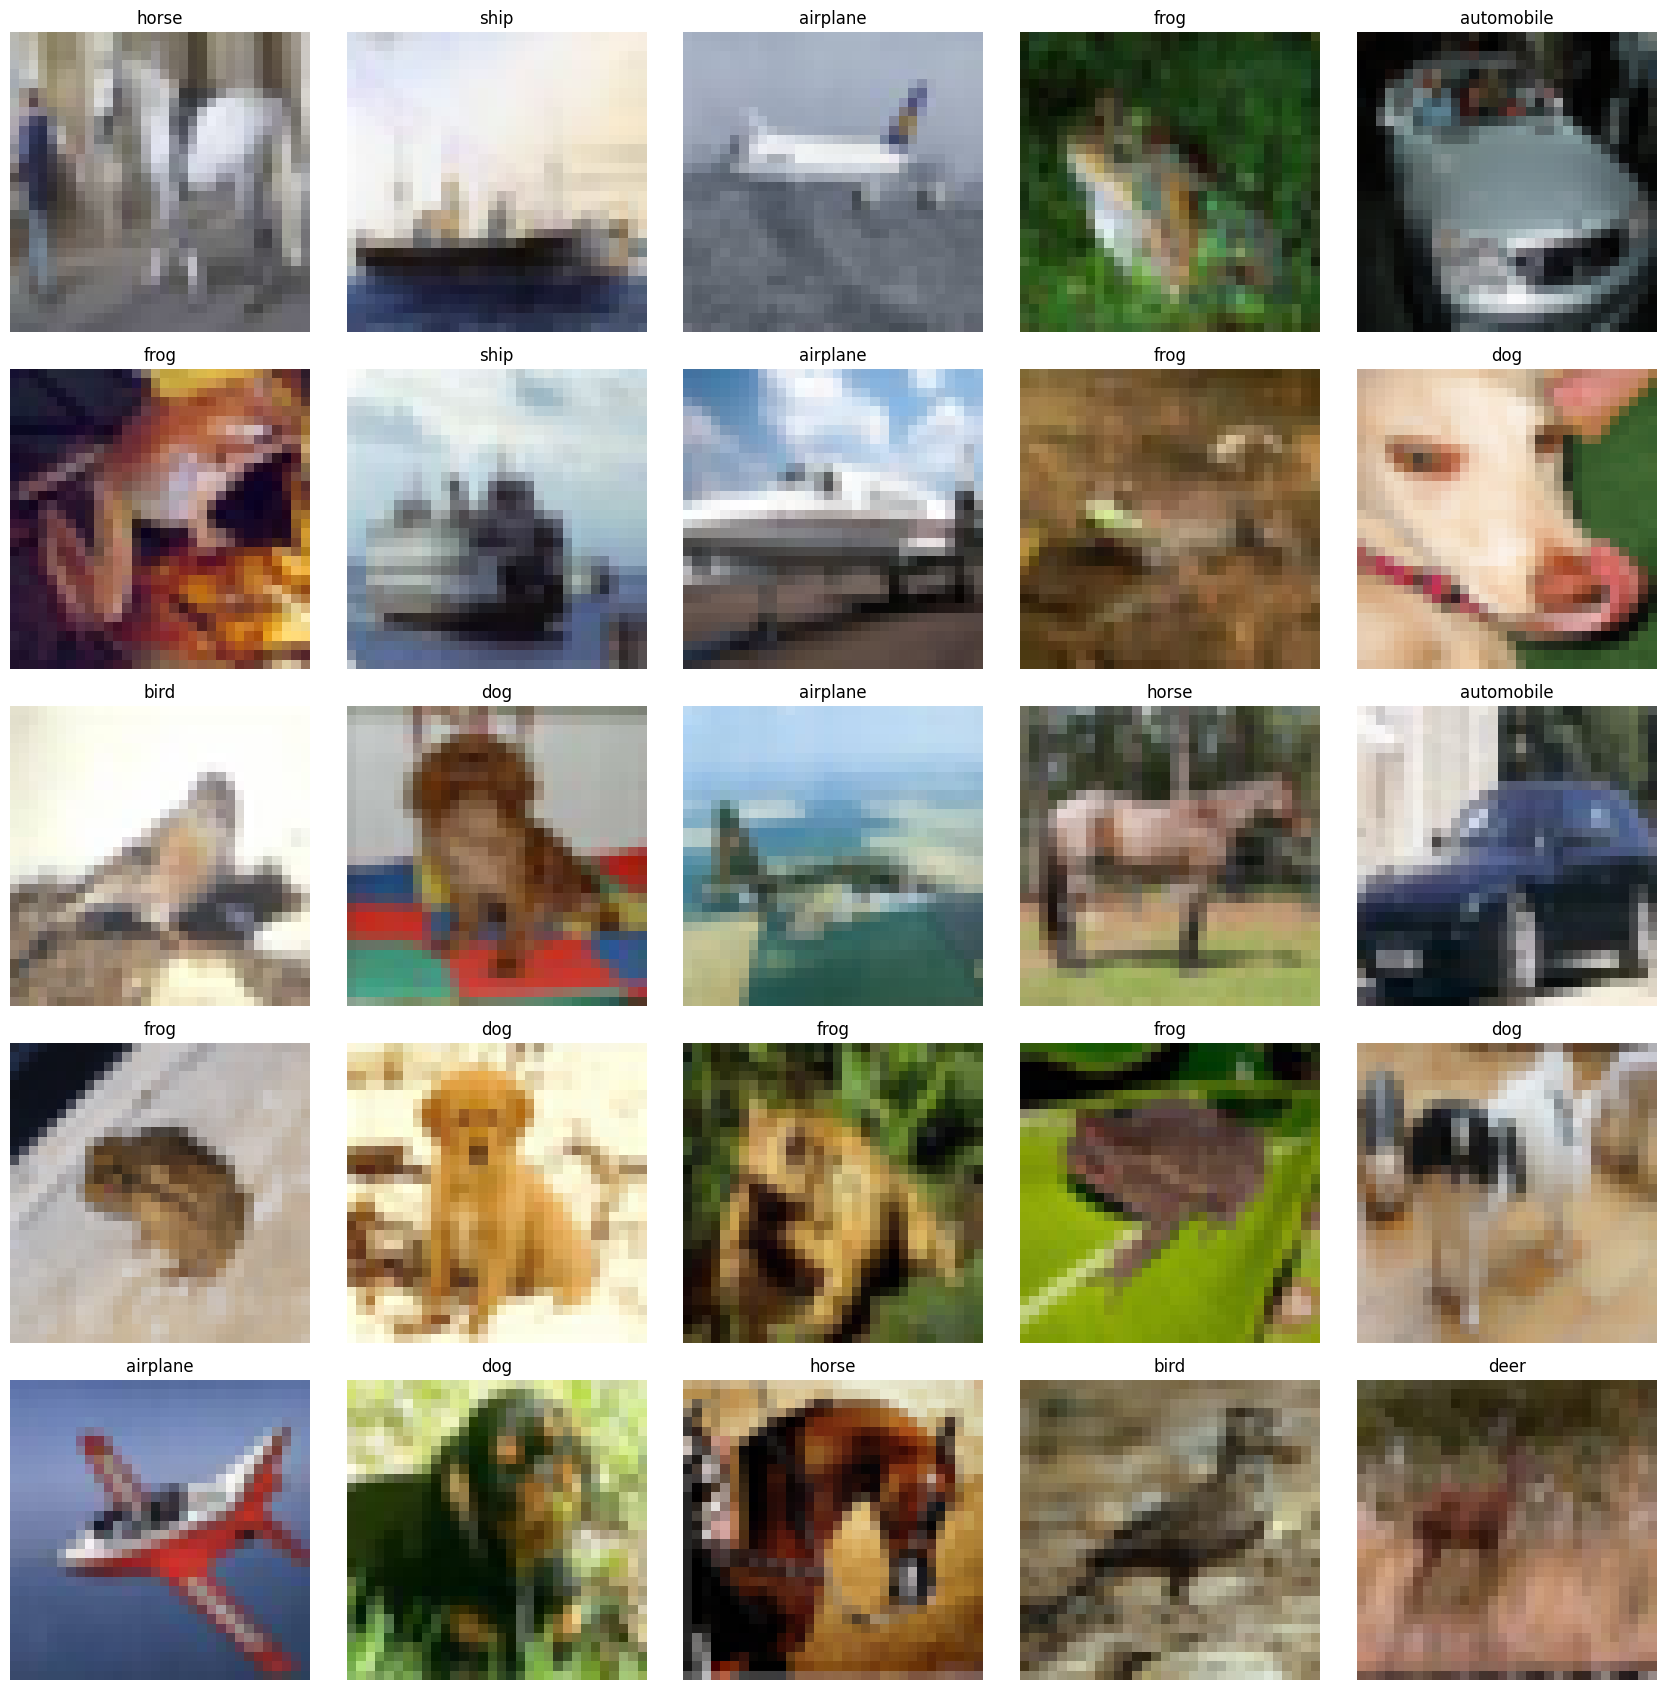

In [4]:
plot_images(train_images, train_labels)

**Funktionen**
1. [layers.RandomTranslation(height_factor, width_factor, fill_mode)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation)
    * height_factor/width_factor: Zahl zwischen 0 & 1, gibt den Anteil an, um welchen das Bild verschoben wird (z.B. 0.2 = Bild wird um +-20% verschoben)
    * fill_mode: "reflect", "constant", "nearest", "wrap"

2. [layers.RandomZoom(height_factor, width_factor, fill_mode)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom)
    * height_factor/width_factor: positiver float, gibt den Faktor an, um welchen gezoomt wird
    * fill_mode: "reflect", "constant", "nearest", "wrap"

3. [layers.RandomContrast(factor)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast)
    * factor: positiver float, gibt den Kontrastfaktor an, um welchen dieser verändert wird (z.B. 0.1 = Kontrast wird um +-10% verändert)

4. [layers.RandomRotation(factor, fill_mode)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)
    * factor: positiver float, Anteil von zwei Pi, um welchen das Bild rotiert wird (z.B. 0.5 = Bild wird um +-Pi gedreht)

5. [layers.RandomFlip(mode)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip)
    * mode: "horizontal", "vertical", "horizontal_and_vertical"

* mehr Optionen: https://www.tensorflow.org/guide/keras/preprocessing_layers

In [5]:
preprocessing_model = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),

    keras.layers.RandomFlip("horizontal"),
    #keras.layers.RandomHeight(0.3),
    #keras.layers.RandomRotation(0.2),
    #keras.layers.RandomWidth(0.3),
    #keras.layers.RandomZoom(0.3),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    #keras.layers.RandomBrightness([0,0.001]),
    keras.layers.RandomContrast(0.2)
])
preprocessing_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 32, 32, 3)      │             0 │
│ (RandomContrast)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Visualisiert die Preprocessed Bilder am Training Subset. Stelle sicher, dass die Bilder noch sinnvoll aussehen.

In [ ]:
plot_preprocessed_images(preprocessing_model, train_images)

### Abschnitt 2. CNN Modell
**Aufgabe**: Erstelle dein eigenes CNN Modell mit beliebigen Layers

Erinnerung: Es gibt 10 Klassen

**Funktionen**
- [Conv2D(filters, kernel_size, strides, padding)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [MaxPooling2D(pool_size)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- [AveragePooling2D(pool_size)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)
- [BatchNormalization()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
- [Dropout(rate)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
- [Dense(units, activation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [6]:
cnn_model = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
    
])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

Model adopted from: https://www.kaggle.com/code/muhammadibrahimqasmi/cifar-10-cnn-image-classification

Kombiniert das preprocessing und CNN Modell

In [7]:
inputs = tf.keras.Input(shape=(32,32,3))
output1 = preprocessing_model(inputs)
output2 = cnn_model(output1)
model= tf.keras.Model(inputs=inputs,outputs=output2)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │       816,938 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Abschnitt 3. Trainieren des Modells
**Aufgabe**: Kompiliere und trainiere dein Modell mit [model.compile(...)](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

In [8]:
model.compile(optimizer="adam", metrics=["accuracy"], loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [9]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

**Aufgabe**: Verwende [model.fit(...)](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), um das Modell zu trainieren. Wählen eine geeignete Anzahl von Epochs und eine geeignete batch Size. Mit Google Colab sollten auch Modelle mit höheren Epochen-Anzahlen relativ schnell trainieren (z.B. 20)

Erinnerung: Das training Dataset ist train_images und train_labels

In [10]:
history = model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(validation_images,validation_labels), callbacks=[checkpoint, early_stopping])

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 69ms/step - accuracy: 0.3026 - loss: 2.1619 - val_accuracy: 0.5050 - val_loss: 1.3842
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - accuracy: 0.5149 - loss: 1.3406 - val_accuracy: 0.4860 - val_loss: 1.5085
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.5966 - loss: 1.1324 - val_accuracy: 0.6735 - val_loss: 0.9208
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - accuracy: 0.6487 - loss: 1.0031 - val_accuracy: 0.6925 - val_loss: 0.9057
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.6793 - loss: 0.9202 - val_accuracy: 0.7440 - val_loss: 0.7539
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.7132 - loss: 0.8386 - val_accuracy: 0.7555 - val_loss: 0.6891
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - accuracy: 0.7269 - loss: 0.7857 - val_accuracy: 0.7540 - val_loss: 0.7108
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 

### Breakpoint
Während das Modell trainiert wird, können wir über eure Lösungen reden (bzw. Fragen klären)

---

Rollback zum besten Modell (Optional)

In [11]:
model = tf.keras.models.load_model('best_model.keras')

### Abschnitt 4. Bewertung des Modells

**Aufgabe**: Bewerte dein Modell mit [model.evaluate(x,y)](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate). Führe die Funktionen unten aus.

Was macht dein Modell richtig und was falsch? Woran könnte das liegen?

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print(test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8464 - loss: 0.4580
0.4427875578403473
0.8526250123977661


Stellt den Verlust, den Validierungsverlust, die Genauigkeit und die Validierungsgenauigkeit dar.

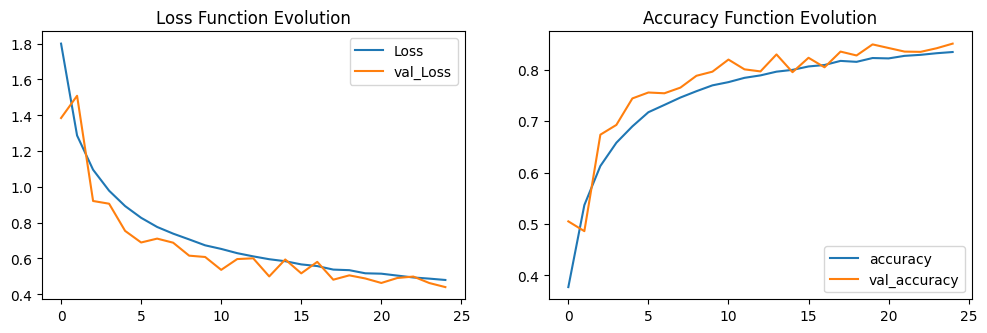

In [13]:
plot_history(history)

Stellt die Confusion Matrix dar.

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


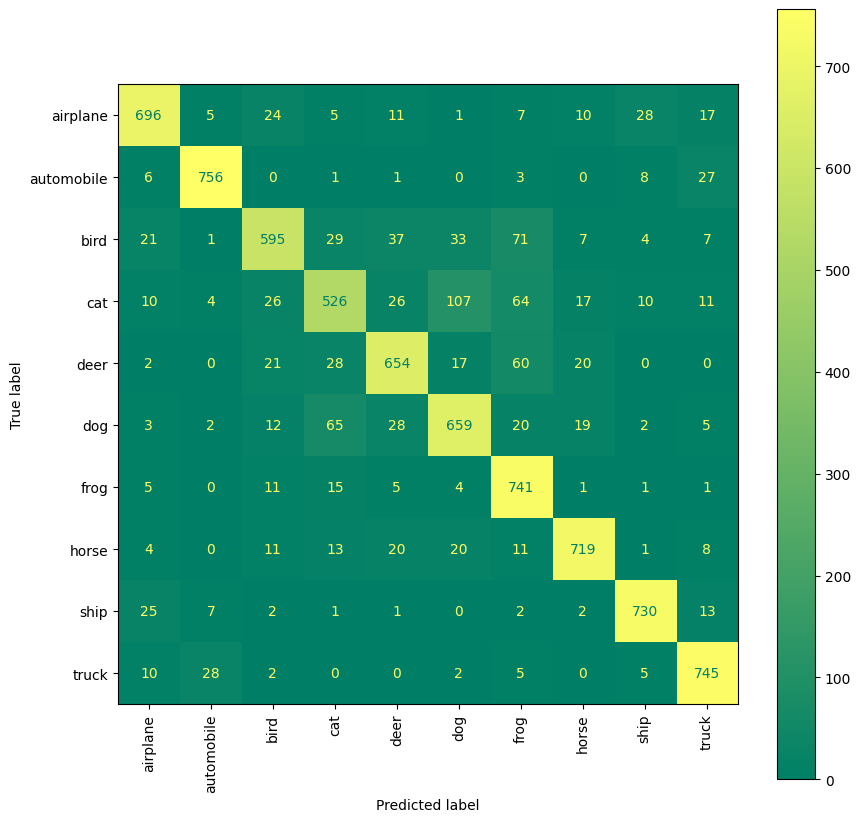

In [14]:
plot_confusion(model, test_images, test_labels, class_names)

Stellt die Bilder und die Wahrscheinlichkeiten der einzelnen Klassen dar, die das Modell vorhergesagt hat. Die richtige Klasse ist grün dargestellt, eine falsche Vorhersage ist rot dargestellt.

Zeigt eine zufällige Teilmenge von Bildern an, so dass Sie die Funktion mehrmals ausführen können, um verschiedene Bilder zu sehen.

Syntax der Überschrift: Predicted Class, Probability, (True Class)

Klassen: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


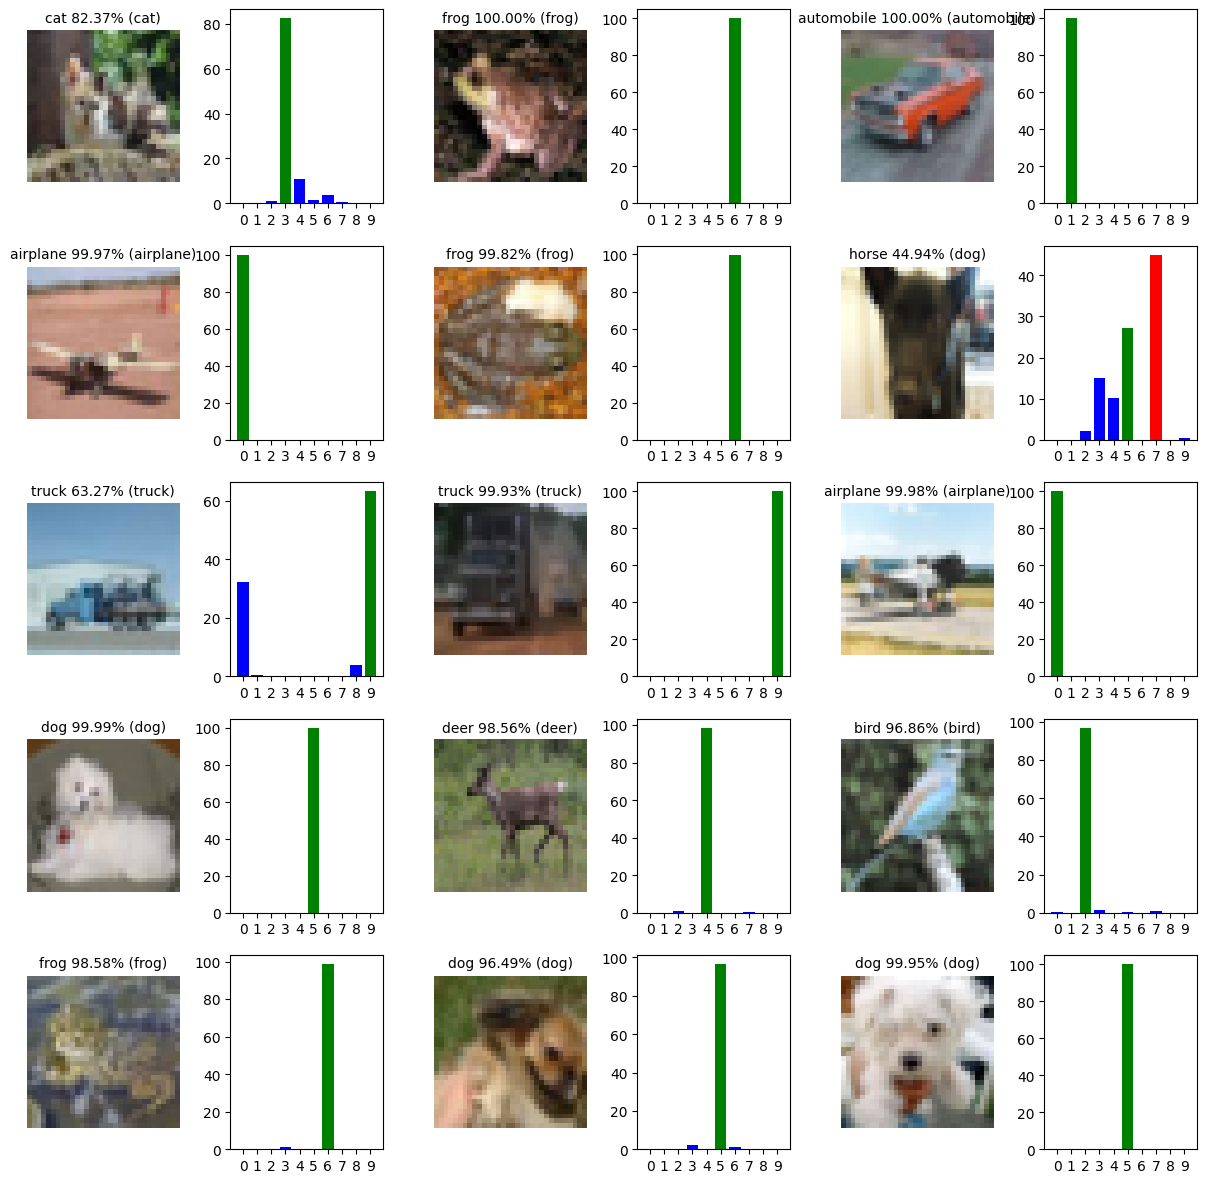

In [15]:
plot_predictions(model, test_images, test_labels, class_names)